In [103]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from PLOTTING import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [166]:
config="2"
def inelasticA(config):
    r.gErrorIgnoreLevel = r.kError  # Suppress Info and Warning messages

    gStyle.SetOptStat(0)
    gStyle.SetOptFit(1)

    #_____bring in config values______#
    coinVector=CONFIG.Function_JSON("GEN"+config,"../config/coin.cfg")
    he3spot=CONFIG.Function_JSON("GEN"+config+"He3","../config/spotsize.cfg")
    he3spotsim=CONFIG.Function_JSON("GEN"+config+"He3sim","../config/spotsize.cfg")
    
    #here, set coincidence cut and spot cut values
    coinSigma=3
    coin_low=coinVector[0]-coinSigma*coinVector[1]
    coin_high=coinVector[0]+coinSigma*coinVector[1]   
    #-------------------------------------
    rootfilenp = (f"../outfiles/Pass1/QE_data_GEN{config}_sbs100p_nucleon_np_model2.root")
    rootfilep = (f"../outfiles/Pass1/QE_sim_GEN{config}_sbs100p_nucleon_np_model2.root")
    if config == "4":
        config = "4b"
    
    C = TChain("Tout")
    B = TChain("Tout")
    
    C.Add(rootfilenp)
    B.Add(rootfilep)

    dx_p, dy_p, W2_p, coin_p,fnucl  = array.array('d', [0]),array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    dx_np, dy_np, W2_np, coin_np, weight = array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    helicity_p, IHWP_p, runnum_p = array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    helicity_np, IHWP_np, runnum_np= array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    
    # Disable all branches initially
    C.SetBranchStatus("*", 0)
    B.SetBranchStatus("*", 0)

    # Enable specific branches
    branches = ["dx", "dy", "W2", "helicity", "IHWP", "runnum", "coinCut", "coin_time"]
    b2=["dx", "dy", "W2"]
    for branch in branches:
        C.SetBranchStatus(branch, 1)
    for branch in b2:
        B.SetBranchStatus(branch, 1)

    B.SetBranchStatus("weight", 1)
    B.SetBranchStatus("fnucl",1)
    # Set branch addresses
    C.SetBranchAddress("dx", dx_np)
    B.SetBranchAddress("dx", dx_p)
    C.SetBranchAddress("dy", dy_np)
    B.SetBranchAddress("dy", dy_p)
    C.SetBranchAddress("W2", W2_np)
    B.SetBranchAddress("W2", W2_p)
    C.SetBranchAddress("helicity", helicity_np)
    #B.SetBranchAddress("helicity", helicity_p)
    C.SetBranchAddress("IHWP", IHWP_np)
    #B.SetBranchAddress("IHWP", IHWP_p)
    C.SetBranchAddress("coin_time", coin_np)
    #B.SetBranchAddress("coin_time", coin_pp)
    C.SetBranchAddress("runnum", runnum_np)
    #B.SetBranchAddress("runnum", runnum_p)
    B.SetBranchAddress("weight", weight)
    B.SetBranchAddress("fnucl", fnucl)
    
    # Assuming the variables are already defined or loaded from the ROOT file
    
    if config=="2":
        W2max, W2min = 1.4, 0
    if config=="3":
        W2max, W2min = 1.4, 0
    if config == "4":
        W2max, W2min = 2, -1.2
        
    nbins = 100
    xmin, xmax = -4, 2.5
    if config=="2":
        xmin=-5.5
        xmax=2.8    
    
    
    hbg = TH1F("hbg","Background ;dx;Entries", nbins, xmin, xmax)
    hbg_plus = TH1F("hbg_plus","Background -;Time (ns);Entries", nbins, xmin, xmax)
    hbg_minus = TH1F("hbg_minus","Background + ;dx;Entries", nbins, xmin, xmax)
    hdxdy=r.TH2F("hdxdy", "dX vs dY", nbins, -4, 4, nbins, -4, 4)
    
    # JSONManager part is omitted for now

    nEntries_np = C.GetEntries()
  
    
    #spot imports for dx,dy high and low
    outside=1.4
    hiydata=he3spot[1]+.1;
    hiydata=outside
    lowydata=he3spot[0]-.1;
    lowydata=-outside
    hixdatan=he3spotsim[7];
    lowxdatan=he3spotsim[6];
    hixdatap=he3spotsim[5];
    lowxdatap=he3spotsim[4];
    
    # Data loop
    for i in range(nEntries_np):
        C.GetEntry(i)
        
        if IHWP_np[0] == 1:
            helicity_np[0] *= -1
        elif IHWP_np[0] == -1:
            helicity_np[0] *= 1
        else:
            continue
        ycut = lowydata < dy_np[0] < hiydata
        coin_cut_np = coin_low < coin_np[0] < coin_high and W2min < W2_np[0] < W2max
        pcut=dx_np[0]<hixdatap and dx_np[0]>lowxdatap and dy_np[0]<hiydata and dy_np[0]>lowydata
        ncut=dx_np[0]<hixdatan and dx_np[0]>lowxdatan and dy_np[0]<hiydata and dy_np[0]>lowydata
        
        
        if coin_cut_np and not ycut and runnum_np[0] > 2165:
            hbg.Fill(dx_np[0])
            if helicity_np[0] == 1:
                hbg_plus.Fill(dx_np[0])
            if helicity_np[0] == -1:
                hbg_minus.Fill(dx_np[0])
        if coin_cut_np and runnum_np[0] > 2165:
            hdxdy.Fill(dy_np[0], dx_np[0])

    dylow=lowydata
    dyhi=hiydata
    return Function_HIST2NP(hbg), Function_HIST2NP(hbg_plus),Function_HIST2NP(hbg_minus),hdxdy,dylow,dyhi

In [167]:
hbg,hbg_plus,hbg_minus,hdxdy,dylow,dyhi=inelasticA("3")

Error in <THashList::Delete>: A list is accessing an object (0xc1fcf10) already deleted (list name = THashList)


In [168]:
def Function_PLOT2DROOTHIST(hist, title, filename,count_ranges):
    from matplotlib.colors import LogNorm
    from matplotlib.colors import PowerNorm

    from IPython.display import Image, display
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import ROOT as r
    import array
    import os
    """Plot a ROOT 2D histogram using Matplotlib"""
    colors = ['dodgerblue', '#f2be44','red']
    colors = ['black', 'magenta', '#fc9662', 'orange']
    colors = ['white','black','purple', 'red','#fc9662','orange','yellow']
    colors = ['white', 'red','orange','yellow']
    colors = ['white', 'dodgerblue','mediumaquamarine','gold','yellow']
    #colors = ['#000004', '#b63679', '#fc9662', '#fcffa4']
    #colors = ['white', 'red','dodgerblue']

#norm=PowerNorm(gamma=2.4)





#adding vertical shaded regions to illustrate the cut
    plt.figure(figsize=(8, 6))


    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
    x_edges, y_edges, data = Function_EXTRACTHIST(hist)
    
   
    plt.pcolormesh(x_edges, y_edges, data.T, shading='auto', cmap=cmap)
    plt.colorbar()
    fs=15
    for count_range_min, count_range_max in count_ranges:
        plt.axvspan(count_range_min, count_range_max, color='red', alpha=0.15)
        plt.axvline(count_range_min, color='black', linestyle='-', linewidth=1)
        plt.axvline(count_range_max, color='black', linestyle='-', linewidth=1)
    plt.title(title,fontsize=fs)
    plt.xlabel(r'$\Delta y$',fontsize=fs,fontweight='bold')
    plt.ylabel(r'$\Delta x$',fontsize=fs,fontweight='bold')
    plt.ylim((-3,2))
    plt.xlim((-2,2))

    plt.savefig(f'../plots/{filename}')
    plt.show()
    plt.close()

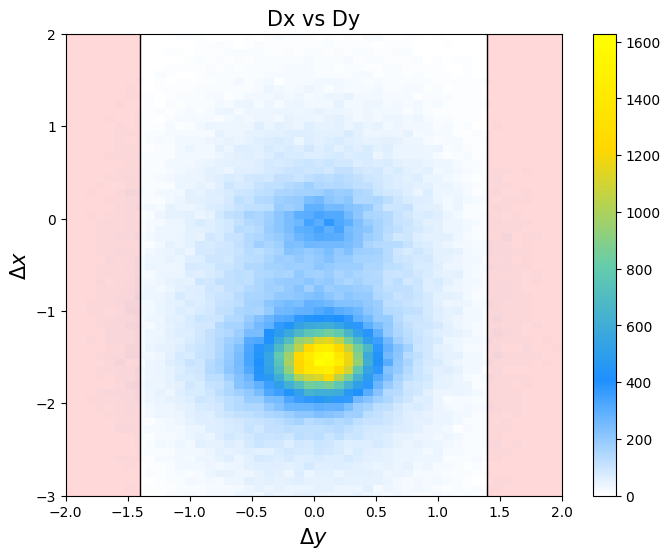

In [169]:
count_ranges = [(-4, dylow), (dyhi, 4)]

Function_PLOT2DROOTHIST(hdxdy,"Dx vs Dy","BGdxvsdy",count_ranges)

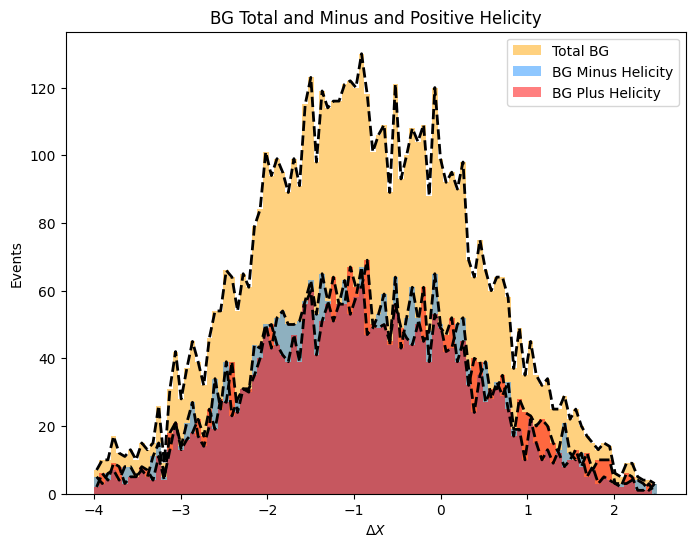

In [170]:
lw=2
plt.figure(figsize=(8,6))
#____________Total BG___________________________________________________________
bin_centers,bin_contents=hbg
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='orange',label="Total BG")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________


#____________BG Plus___________________________________________________________
bin_centers,bin_contents=hbg_plus
bgPlusCounts=np.sum(bin_contents)

plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='dodgerblue',label="BG Minus Helicity")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

#____________BG Minus___________________________________________________________
bin_centers,bin_contents=hbg_minus
bgMinusCounts=np.sum(bin_contents)
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='red',label="BG Plus Helicity")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

plt.legend(loc="upper right")

plt.title("BG Total and Minus and Positive Helicity")
plt.xlabel("$\Delta X$")
plt.ylabel("Events")
plt.savefig(f"../plots/CORRECTIONS_BG{config}")

In [171]:
A=100*(bgPlusCounts-bgMinusCounts)/(bgPlusCounts+bgMinusCounts)

print(f"Asymmetry: {np.round(A,3)}%")

Asymmetry: 0.963%
